In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

## Read data

In [7]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [19]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
target = 'Rings'
continuous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 24
# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define network

In [20]:
class AutoIntModel(nn.Module):
    """
    AutoInt model for regression.
    """
    def __init__(self, input_dim, embedding_dim, num_heads, num_layers, dropout, use_residual=True, use_normalization=True, use_activation=True):
        """
        Initialize the AutoInt model.
        
        Args:
            input_dim (int): Number of input features.
            embedding_dim (int): Embedding dimension for input features.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of self-attention layers.
            dropout (float): Dropout probability.
            use_residual (bool, optional): Whether to use residual connections. Defaults to True.
            use_normalization (bool, optional): Whether to use layer normalization. Defaults to True.
            use_activation (bool, optional): Whether to use activation functions. Defaults to True.
        """
        super(AutoIntModel, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.Dropout(dropout)
        )
        self.use_residual = use_residual
        self.use_normalization = use_normalization
        self.use_activation = use_activation
        
        if use_activation:
            activation = nn.GELU()
        else:
            activation = nn.Identity()
        
        if use_normalization:
            normalization = nn.LayerNorm(embedding_dim)
        else:
            normalization = nn.Identity()
        
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout, batch_first=True),
                normalization,
                activation,
                nn.Dropout(dropout)
            )
            for _ in range(num_layers)
        ])
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, 1)
        )
    
    def forward(self, x):
        """
        Perform forward pass through the AutoInt model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Model output.
        """
        x = self.embedding(x)
        
        for attention_layer in self.attention_layers:
            if self.use_residual:
                residual = x
                x, _ = attention_layer[0](x, x, x)
                x = attention_layer[1:](x)
                x = x + residual
            else:
                x, _ = attention_layer[0](x, x, x)
                x = attention_layer[1:](x)
        
        x = self.fc(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
# Define hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
params = {'embedding_dim': 32, 'num_heads': 2, 
          'num_layers': 2, 
          'dropout': 0.2561941946377331
         }

# Initialize the model
model = AutoIntModel(input_dim, **params).to(device)

## Define training loop

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 9.1284, Val Loss: 5.2954


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 6.0491, Val Loss: 4.0721


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 5.0853, Val Loss: 4.1460


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 4.7794, Val Loss: 3.7409


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 4.6242, Val Loss: 3.7593


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 4.5104, Val Loss: 3.8995


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 4.3942, Val Loss: 3.6739


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 4.3399, Val Loss: 3.6765


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 4.3092, Val Loss: 3.6835


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 4.3221, Val Loss: 3.6675


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 4.3439, Val Loss: 3.6654


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 4.3318, Val Loss: 3.6874


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 4.3026, Val Loss: 3.6659


  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

Early stopping at epoch 14


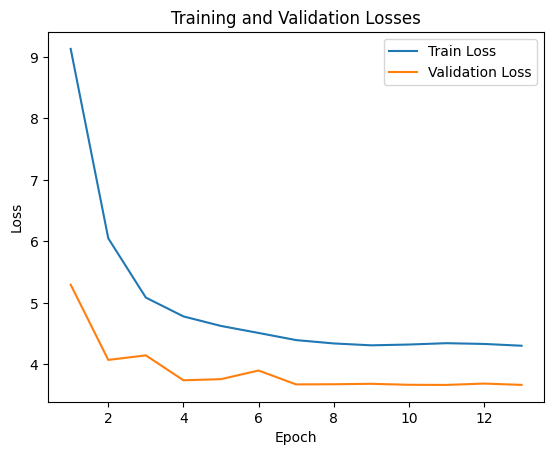

In [23]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize best_val_loss here
best_model_state = None
patience_counter = 0
early_stopping_patience = 3  # Define the patience for early stopping


EPOCHS = 20
initial_lr = 0.001  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        mask = mask.view(-1, 1) 
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image)
            mask = mask.view(-1, 1)
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

     # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [27]:
# Inference

test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([[ 9.7133],
        [ 9.6166],
        [10.1554],
        ...,
        [12.7128],
        [13.0745],
        [ 8.5461]], device='cuda:0')

## Hyperparameter tune 

In [18]:
def train_model(params):
    """
    Train the FT-Transformer model with the given hyperparameters.
    
    Args:
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = X_train_tensor.shape[1]
    embedding_dim = params['embedding_dim']
    num_heads = params['num_heads']
    num_layers = params['num_layers']
    dropout = params['dropout']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    early_stopping_patience = params['early_stopping_patience']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the FT-Transformer model
    model = AutoIntModel(input_dim, embedding_dim, num_heads, num_layers, dropout).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        # Create train and validation datasets using the indices
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = torch.utils.data.TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        # Create data loaders for train and validation datasets
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Initialize variables for early stopping
        best_val_rmse = float('inf')  # Initialize best_val_rmse here
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            # Iterate over the training batches
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            # Iterate over the validation batches
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            # Concatenate the validation predictions and targets
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            # Calculate validation RMSE
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            # Check for early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Store the best validation RMSE for the current fold
        best_val_rmse_folds.append(best_val_rmse)
        
        # Load the best model state for the current fold
        model.load_state_dict(best_model_state)
    
    # Calculate the average validation RMSE across all folds
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    embedding_dim = trial.suggest_int('embedding_dim', 32, 128, step=16)
    num_heads = trial.suggest_int('num_heads', 2, embedding_dim // 16)
    
    while embedding_dim % num_heads != 0:
        num_heads -= 1
    
    params = {
        'embedding_dim': embedding_dim,
        'num_heads': num_heads,
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'num_epochs': 200,
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'early_stopping_patience': 10
    }
    
    avg_val_rmse = train_model(params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(multivariate=True))

# # Optimize the hyperparameters
study.optimize(objective, timeout=3600 * 10)

# # Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)


[I 2024-04-17 10:16:21,703] A new study created in memory with name: no-name-747b49cf-996e-48fa-8c36-3afe43883275


Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.3719
Epoch [2/200], Validation RMSE: 2.2503
Epoch [3/200], Validation RMSE: 1.9806
Epoch [4/200], Validation RMSE: 1.9549
Epoch [5/200], Validation RMSE: 1.9959
Epoch [6/200], Validation RMSE: 1.9633
Epoch [7/200], Validation RMSE: 1.9486
Epoch [8/200], Validation RMSE: 1.9455
Epoch [9/200], Validation RMSE: 1.9383
Epoch [10/200], Validation RMSE: 1.9567
Epoch [11/200], Validation RMSE: 1.9255
Epoch [12/200], Validation RMSE: 1.9204
Epoch [13/200], Validation RMSE: 1.9237
Epoch [14/200], Validation RMSE: 1.9304
Epoch [15/200], Validation RMSE: 1.9391
Epoch [16/200], Validation RMSE: 1.9172
Epoch [17/200], Validation RMSE: 1.9558
Epoch [18/200], Validation RMSE: 1.9270
Epoch [19/200], Validation RMSE: 1.9230
Epoch [20/200], Validation RMSE: 1.9163
Epoch [21/200], Validation RMSE: 1.9177
Epoch [22/200], Validation RMSE: 1.9169
Epoch [23/200], Validation RMSE: 1.9121
Epoch [24/200], Validation RMSE: 1.9234
Epoch [25/200], Validation RMSE: 1.9132
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9120
Epoch [2/200], Validation RMSE: 1.9408
Epoch [3/200], Validation RMSE: 1.9125
Epoch [4/200], Validation RMSE: 1.9034
Epoch [5/200], Validation RMSE: 1.9008
Epoch [6/200], Validation RMSE: 1.9050
Epoch [7/200], Validation RMSE: 1.9218
Epoch [8/200], Validation RMSE: 1.9357
Epoch [9/200], Validation RMSE: 1.9226
Epoch [10/200], Validation RMSE: 1.9069
Epoch [11/200], Validation RMSE: 1.9031
Epoch [12/200], Validation RMSE: 1.9136
Epoch [13/200], Validation RMSE: 1.9111
Epoch [14/200], Validation RMSE: 1.9046
Epoch [15/200], Validation RMSE: 1.9028
Early stopping at epoch 15
Fold [3/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9213
Epoch [2/200], Validation RMSE: 1.8951
Epoch [3/200], Validation RMSE: 1.9031
Epoch [4/200], Validation RMSE: 1.9045
Epoch [5/200], Validation RMSE: 1.9145
Epoch [6/200], Validation RMSE: 1.8960
Epoch [7/200], Validation RMSE: 1.9120
Epoch [8/200], Validation RMSE: 1.8946
Epoch [9/200], Validation RMSE: 1.9005
Epoch [10/200], Validation RMSE: 1.8927
Epoch [11/200], Validation RMSE: 1.8958
Epoch [12/200], Validation RMSE: 1.8994
Epoch [13/200], Validation RMSE: 1.9060
Epoch [14/200], Validation RMSE: 1.9028
Epoch [15/200], Validation RMSE: 1.8971
Epoch [16/200], Validation RMSE: 1.9045
Epoch [17/200], Validation RMSE: 1.9003
Epoch [18/200], Validation RMSE: 1.8984
Epoch [19/200], Validation RMSE: 1.8969


[I 2024-04-17 10:31:07,972] Trial 0 finished with value: 1.8966493606567383 and parameters: {'embedding_dim': 32, 'num_heads': 2, 'num_layers': 2, 'dropout': 0.2561941946377331, 'batch_size': 24, 'learning_rate': 0.0007779172855310895}. Best is trial 0 with value: 1.8966493606567383.


Epoch [20/200], Validation RMSE: 1.8933
Early stopping at epoch 20
Average Validation RMSE across folds: 1.8966
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.1373
Epoch [2/200], Validation RMSE: 1.9443
Epoch [3/200], Validation RMSE: 1.9565
Epoch [4/200], Validation RMSE: 1.9251
Epoch [5/200], Validation RMSE: 1.9400
Epoch [6/200], Validation RMSE: 1.9488
Epoch [7/200], Validation RMSE: 1.9851
Epoch [8/200], Validation RMSE: 1.9383
Epoch [9/200], Validation RMSE: 1.9115
Epoch [10/200], Validation RMSE: 1.9778
Epoch [11/200], Validation RMSE: 1.9604
Epoch [12/200], Validation RMSE: 1.9014
Epoch [13/200], Validation RMSE: 1.9259
Epoch [14/200], Validation RMSE: 1.9041
Epoch [15/200], Validation RMSE: 1.9268
Epoch [16/200], Validation RMSE: 1.9268
Epoch [17/200], Validation RMSE: 1.8967
Epoch [18/200], Validation RMSE: 1.8956
Epoch [19/200], Validation RMSE: 1.9018
Epoch [20/200], Validation RMSE: 1.9038
Epoch [21/200], Validation RMSE: 1.9276
Epoch [22/200], Validation RMSE: 1.9102
Epoch [23/200], Validation RMSE: 1.9211
Epoch [24/200], Validation RMSE: 1.8944


[W 2024-04-17 10:33:05,401] Trial 1 failed with parameters: {'embedding_dim': 112, 'num_heads': 3, 'num_layers': 3, 'dropout': 0.16598804800702188, 'batch_size': 70, 'learning_rate': 0.0021076087533187645} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/3878675221.py", line 140, in objective
    avg_val_rmse = train_model(params)
  File "/tmp/ipykernel_34/3878675221.py", line 58, in train_model
    for batch_X, batch_y in train_loader:
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 674, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/lib/python3.10/site-packages/to

KeyboardInterrupt: 

### Hyperparameter search space is too long but the best results obtained were:
{'embedding_dim': 32, 'num_heads': 2, 'num_layers': 2, 'dropout': 0.2561941946377331, 'batch_size': 24, 'learning_rate': 0.0007779172855310895}. Best is trial 0 with value: 1.8966493606567383.